# SuperSet

In this notebook we aim to discover a way to represnet all of our finger prints

## Method 1:

aim is to clean up the data and add 2 new columns such as **Drug_name** and **bond_type** then i will input them in a 1D CNN and use XAI techniques to see why a model has made a specific prediction.


first we are going to clean up and change the format of the data

we are going to have the following:
* Residues 
* Interactions
* Frames


In [26]:
import pandas as pd
import os

# Define input config for each drug
drug_files = {
    "AMP": {
        "path": "Data/Original/fp_comp_dataframe_AMP.csv",
        "drug_name": "AMP",
        "bond_type": "inward"
    },
    "COC": {
        "path": "Data/Original/fp_comp_dataframe_COC.csv",
        "drug_name": "COC",
        "bond_type": "outward"
    },
    "MDMA":{
        "path": "Data/Original/fp_comp_dataframe_MDMA.csv",
        "drug_name": "MDMA",
        "bond_type": "inward"
    }
}

# Create output directory if it doesn't exist
os.makedirs("Data/superset", exist_ok=True)

# Processing loop
for drug, config in drug_files.items():
    # Load original CSV
    df = pd.read_csv(config["path"])

    # STEP 1: Drop the third row (index 2), which contains mostly NaN values
    df_cleaned = df.drop(index=2).reset_index(drop=True)

    # STEP 2: Extract header rows
    header_residues = df_cleaned.iloc[0]
    header_types = df_cleaned.iloc[1]

    # STEP 3: Create MultiIndex
    multi_index = pd.MultiIndex.from_arrays([header_residues, header_types])

    # STEP 4: Drop header rows
    df_cleaned = df_cleaned.drop(index=[0, 1]).reset_index(drop=True)

    # STEP 5: Apply MultiIndex
    df_cleaned.columns = multi_index

    # STEP 6: Insert correct frame column
    frame_col = df.iloc[3:, 0].reset_index(drop=True)
    df_cleaned.insert(0, ("meta", "frame"), frame_col.astype(int))

    # STEP 6.5: Drop redundant ("protein", "interaction") column if present
    if ("protein", "interaction") in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=[("protein", "interaction")])

    # STEP 7: Convert numerics
    df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')

    # STEP 8: Fill NaN with 0
    df_cleaned = df_cleaned.fillna(0)

    # STEP 9: Add meta columns
    df_cleaned[("meta", "bond_type")] = config["bond_type"]
    df_cleaned[("meta", "drug_name")] = config["drug_name"]

    # STEP 10: Reorder columns
    df_cleaned = df_cleaned[
        [col for col in df_cleaned.columns if col[0] != "meta" or col[1] == "frame"] +
        [("meta", "bond_type"), ("meta", "drug_name")]
    ]

    # Save cleaned version
    output_path = f"Data/superset/approach_1/cleaned_{config['drug_name']}.csv"
    df_cleaned.to_csv(output_path, index=False)
    print(f"Saved cleaned CSV for {drug}: {output_path}")


Saved cleaned CSV for AMP: Data/superset/approach_1/cleaned_AMP.csv
Saved cleaned CSV for COC: Data/superset/approach_1/cleaned_COC.csv
Saved cleaned CSV for MDMA: Data/superset/approach_1/cleaned_MDMA.csv


C:\Users\amirt\AppData\Local\Temp\ipykernel_13888\1353992735.py:56: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\amirt\AppData\Local\Temp\ipykernel_13888\1353992735.py:56: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\amirt\AppData\Local\Temp\ipykernel_13888\1353992735.py:56: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')


### Numpy format 

loading the cleaned files, then extract:

* x = all numeric feature columns (residue fingerprints)
* y = bond_type label will be encoded such as 0= inward, 1= outward, 2= occluded

thnen converting them into NumPy arrays 
and stakcing them for model training.

**outcome:**

```
X shape: (1282, 46)
y shape: (1282,)
Classes: ['inward' 'outward']

```

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os

# List of cleaned files to include
drug_files = ["AMP", "COC"]  # others can be added here

X_list = []
y_list = []

for drug in drug_files:
    # Load cleaned CSV
    df = pd.read_csv(f"Data/superset/approach_1/cleaned_{drug}.csv", header=[0, 1])

    # Extract feature matrix (drop all 'meta' columns)
    X = df.loc[:, df.columns.get_level_values(0) != "meta"]
    X = X.to_numpy(dtype=np.float32)

    # Extract and encode bond_type as target
    y = df[("meta", "bond_type")]
    y_list.append(y)

    # Append features
    X_list.append(X)

# Combine all drugs into a single dataset
X_all = np.vstack(X_list)

# Encode labels
le = LabelEncoder()
y_all = le.fit_transform(pd.concat(y_list).values)

# Shapes
print("X shape:", X_all.shape)
print("y shape:", y_all.shape)
print("Classes:", le.classes_)

# Save numpy arrays
output_dir = "Data/superset/approach_1/num"
os.makedirs(output_dir, exist_ok=True)

np.save(os.path.join(output_dir, "X_all.npy"), X_all)
np.save(os.path.join(output_dir, "y_all.npy"), y_all)
np.save(os.path.join(output_dir, "y_labels.npy"), le.classes_)

print(f"Saved NumPy arrays to: {output_dir}")


X shape: (1282, 46)
y shape: (1282,)
Classes: ['inward' 'outward']
Saved NumPy arrays to: Data/superset/approach_1/num


In [80]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# STEP 1: Load data
X = np.load("Data/superset/approach_1/num/X_all.npy")
y = np.load("Data/superset/approach_1/num/y_all.npy")
y_labels = np.load("Data/superset/approach_1/num/y_labels.npy", allow_pickle= True)

# STEP 2: Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# STEP 3: PyTorch Dataset
class FingerprintDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # shape: (1, features)

train_dataset = FingerprintDataset(X_train, y_train)
test_dataset = FingerprintDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# STEP 4: 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
input_length = X.shape[1]
num_classes = len(np.unique(y))
model = CNN1D(input_length, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 5: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/50 - Loss: {total_loss:.4f}")

# STEP 6: Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=y_labels))


Epoch 1/50 - Loss: 22.0506
Epoch 2/50 - Loss: 20.4114
Epoch 3/50 - Loss: 18.8914
Epoch 4/50 - Loss: 15.7279
Epoch 5/50 - Loss: 12.1657
Epoch 6/50 - Loss: 8.4809
Epoch 7/50 - Loss: 5.9380
Epoch 8/50 - Loss: 4.2279
Epoch 9/50 - Loss: 2.9953
Epoch 10/50 - Loss: 2.2395
Epoch 11/50 - Loss: 1.7513
Epoch 12/50 - Loss: 1.3162
Epoch 13/50 - Loss: 1.0971
Epoch 14/50 - Loss: 0.9170
Epoch 15/50 - Loss: 0.7867
Epoch 16/50 - Loss: 0.6872
Epoch 17/50 - Loss: 0.6075
Epoch 18/50 - Loss: 0.5417
Epoch 19/50 - Loss: 0.4916
Epoch 20/50 - Loss: 0.4469
Epoch 21/50 - Loss: 0.4061
Epoch 22/50 - Loss: 0.3606
Epoch 23/50 - Loss: 0.3304
Epoch 24/50 - Loss: 0.3006
Epoch 25/50 - Loss: 0.2950
Epoch 26/50 - Loss: 0.2593
Epoch 27/50 - Loss: 0.2448
Epoch 28/50 - Loss: 0.2187
Epoch 29/50 - Loss: 0.2014
Epoch 30/50 - Loss: 0.1914
Epoch 31/50 - Loss: 0.1787
Epoch 32/50 - Loss: 0.1687
Epoch 33/50 - Loss: 0.1641
Epoch 34/50 - Loss: 0.1643
Epoch 35/50 - Loss: 0.1542
Epoch 36/50 - Loss: 0.1332
Epoch 37/50 - Loss: 0.1277
Epoch

In [81]:
# Directory to save model weights
import os
os.makedirs("Data/superset/approach_1/model", exist_ok=True)

# Save model weights (state_dict)
model_path = "Data/superset/approach_1/model/cnn1d_weights.pth"
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to: {model_path}")


Model weights saved to: Data/superset/approach_1/model/cnn1d_weights.pth


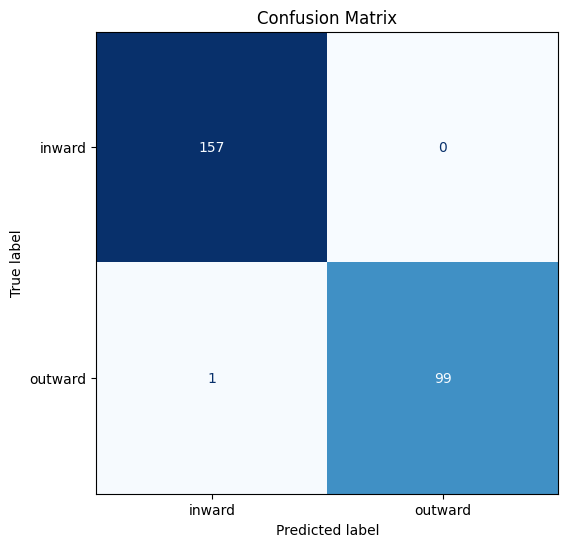

Classification Report:
              precision    recall  f1-score   support

      inward       0.99      1.00      1.00       157
     outward       1.00      0.99      0.99       100

    accuracy                           1.00       257
   macro avg       1.00      0.99      1.00       257
weighted avg       1.00      1.00      1.00       257



In [83]:
#Model Diagnostic 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# STEP 1: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# STEP 2: Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=y_labels))


### Making predictions!

now the aim is to load and clean a new data that the model hasn't seen before, then use the the saved model weights to make predictions. the dtug that i will be using is **MDMA** 

In [84]:
# Load cleaned MDMA CSV
df = pd.read_csv("Data/superset/approach_1/cleaned_MDMA.csv", header=[0, 1])
X_mdma = df.loc[:, df.columns.get_level_values(0) != "meta"].to_numpy(dtype=np.float32)
X_mdma_tensor = torch.tensor(X_mdma).unsqueeze(1)  # shape: (n_samples, 1, features)

# Load model and weights
model = CNN1D(input_length=X_mdma.shape[1], num_classes=2) # need to chaneg to 3 if we have Occluded
model.load_state_dict(torch.load("Data/superset/approach_1/model/cnn1d_weights.pth"))
model.eval()

# Predict
with torch.no_grad():
    outputs = model(X_mdma_tensor)
    preds = torch.argmax(outputs, dim=1)


In [85]:
# Count predictions per class
import numpy as np
unique, counts = np.unique(preds.numpy(), return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls} → {count} frames predicted")


Class 0 → 578 frames predicted
Class 1 → 163 frames predicted


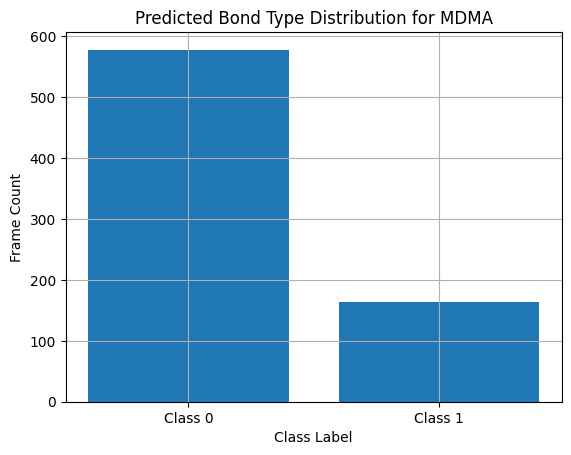

In [86]:
import matplotlib.pyplot as plt

# Convert to counts
plt.bar(unique, counts, tick_label=[f"Class {i}" for i in unique])
plt.title("Predicted Bond Type Distribution for MDMA")
plt.xlabel("Class Label")
plt.ylabel("Frame Count")
plt.grid(True)
plt.show()


In [87]:
label_names = ['inward', 'outward']  # order must match training label encoding
for cls, count in zip(unique, counts):
    print(f"{label_names[cls]}: {count} frames")


inward: 578 frames
outward: 163 frames


### Why model predicted inward and outward?

now it's time to use XAI techniques such as Lime and Shap to undrestand models predictions

* LIME: re-assesses the models input features and checks model response to identify most influential residues
* SHAP: computes score of each attribution per prediction

In [78]:
from lime import lime_tabular
import pandas as pd
import torch
import numpy as np

# Load cleaned AMP (training reference) CSV to get consistent feature names
df_train = pd.read_csv("Data/superset/approach_1/cleaned_AMP.csv", header=[0, 1])
real_feature_names = [f"{a} ({b})" for a, b in df_train.columns if a != "meta"]

# Check shape to avoid IndexError
assert X_all.shape[1] == len(real_feature_names), "Feature count mismatch in X_all"
assert X_mdma.shape[1] == len(real_feature_names), "Feature count mismatch in X_mdma"

# LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_all,
    feature_names=real_feature_names,
    class_names=['inward', 'outward'],  # Only these two were trained
    discretize_continuous=True
)

# Wrapper for prediction
def predict_proba_fn(x):
    x_tensor = torch.tensor(x).unsqueeze(1).float()  # (batch, 1, features)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()


AssertionError: Feature count mismatch in X_mdma

In [77]:
# Choose an index from MDMA
i = 42
explanation = explainer.explain_instance(X_mdma[i].ravel(), predict_proba_fn)
explanation.show_in_notebook()

IndexError: index 44 is out of bounds for axis 0 with size 44

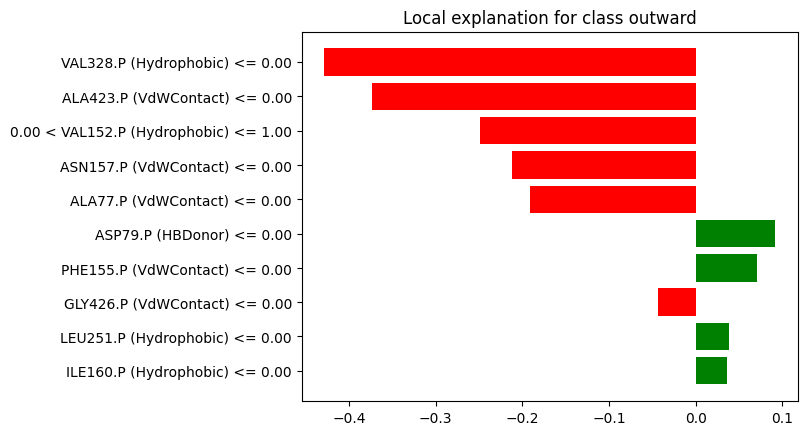

In [73]:
fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')  
plt.show()


### SHAP

In [79]:
import shap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned training CSV to get correct feature names
df_train = pd.read_csv("Data/superset/approach_1/cleaned_AMP.csv", header=[0, 1])
real_feature_names = [f"{a} ({b})" for a, b in df_train.columns if a != "meta"]

# Prepare background from training data
background = torch.tensor(X_all[:200]).unsqueeze(1).float()  # (100, 1, features)

# Prepare MDMA sample(s) to explain
mdma_tensor = torch.tensor(X_mdma).unsqueeze(1).float()  # (n_samples, 1, features)

# Ensure model is in eval mode
model.eval()

# Create SHAP DeepExplainer with PyTorch model
explainer = shap.DeepExplainer(model, background)

# Pick a frame index from MDMA to explain
i = 42  # or any frame index
shap_values = explainer.shap_values(mdma_tensor[i:i+1], check_additivity=False)

# Get predicted class index
pred_class = torch.argmax(model(mdma_tensor[i:i+1])).item()

# Flatten SHAP values if needed (e.g. shape is (44, 2))
shap_vector = shap_values[pred_class][0]
if shap_vector.ndim == 2 and shap_vector.shape[1] == 2:
    shap_vector = shap_vector.sum(axis=1)

# Create a SHAP Explanation object
explanation_obj = shap.Explanation(
    values=shap_vector,
    base_values=explainer.expected_value[pred_class],
    data=X_mdma[i],
    feature_names=real_feature_names
)

# Modern SHAP plot (clean, readable)
shap.plots.waterfall(explanation_obj)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 44 but got size 46 for tensor number 1 in the list.

## Method 2: